# Final project: create an auto transcription program

Create a progam to generate transcripts from an input video. You need to submit an executable python function or class, so that in the test code, the function or class can be imported and called. Your function or class will take two inputs:
```
def auto_transcript(input_file, output_file):
    # input_file is a str contains the path of your input video file.
    # output_file is a str contains the path of the .txt file where you save your transcript.
```
- For the input video, you can record yourself speaking, or you can find a video of a person speaking online.
- The content in the output txt file should look like this:
```
[00:00:00] Bruce: Hi there, let's talk about our final project.
[00:00:05] Bruce: The final project will be an auto transcription program.
...
```

- You will need to seperate the conversation into sentences (you can accomplish it by identifying pauses in audio wave signal), and mark the time of the start of each sentence in the video.
- You will need to use face recognition to determine who is the speaker.
- You will need to perform ASR to generate transcripts. If the person speaks languages other than English, you need to detect the language and translate into English.
- You only need to consider the scenario where only 1 person is presented in the video. However, bonus points will be granted if your program can handle the case where multiple person are presented in the video and speaks in turn. You can use face landmark detection models to detect landmarks off speaker's lips, and then determine if a person's mouth is moving in the video. For example, you can use [Mediapipe](https://mediapipe.readthedocs.io/en/latest/solutions/face_mesh.html) to detect facial landmarks. In this case you will need to output a transcript like this:
```
[00:00:00] Bruce: Hi there, let's talk about our final project.
[00:00:05] Franklin: Sure, what are we going to build for the final project?
[00:00:10] Bruce: The final project will be an auto transcription program.
```

In [ ]:
# Step 0: Import Functions

In [ ]:
# functions for facial recognition

!pip install facenet-pytorch
!pip install torchaudio==2.2.0
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [ ]:
# functions for speech recognition

!pip install moviepy
from moviepy.editor import VideoFileClip

!pip install pydub speechrecognition
from pydub import AudioSegment, silence
import speech_recognition as sr
import os
from datetime import timedelta


In [ ]:
# functions for translation

!pip install transformers -q
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import re


In [ ]:
# load the data(input)

from google.colab import output
input_file = "input.mp4"

# def auto_transcript(input_file, output_file):
    # input_file is a str contains the path of your input video file.
    # output_file is a str contains the path of the .txt file where you save your transcript.


In [ ]:
# Step 1: Facial Recognition

In [ ]:
# setup device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# use the detection model MTCNN
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

# model trained on vggface2 (Git) with InceptionResnetV1
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


Running on device: cpu


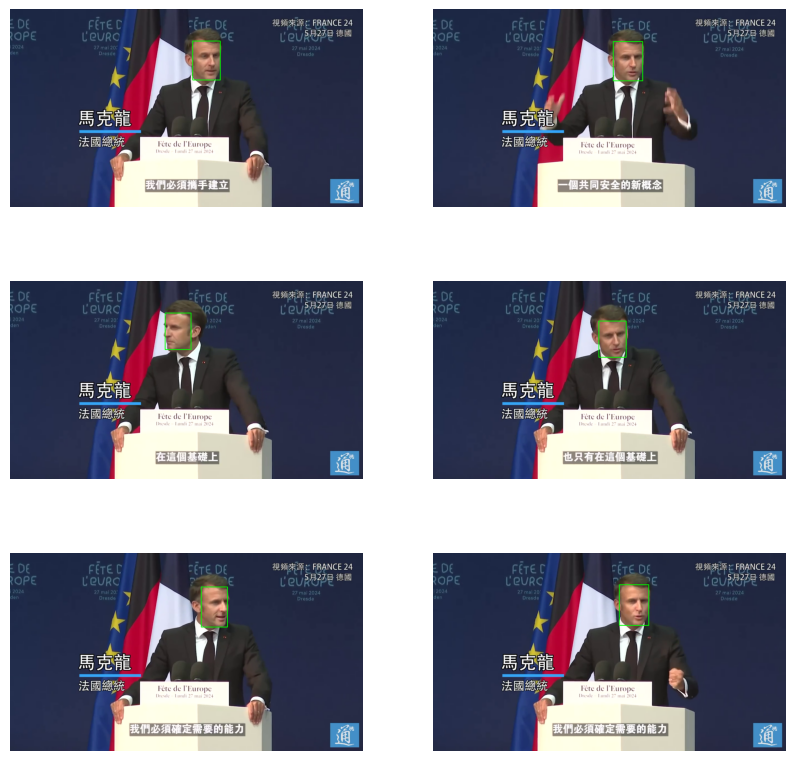

In [ ]:
# analysis the video
video_path = input_file
cap = cv2.VideoCapture(video_path)

frame_count = 0
detected_faces = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 50 == 0:  # read the vedio frame by frame, processing every 50 frames
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # change the image to RGB format
        boxes, _ = mtcnn.detect(rgb_frame)

        if boxes is not None:
            for box in boxes:
                x, y, x2, y2 = box
                detected_faces.append((frame, (int(x), int(y), int(x2 - x), int(y2 - y))))

        if len(detected_faces) >= 8:  # stop when already have 8 images
            break

# release the object
cap.release()

# plot the detected face
plt.figure(figsize=(10, 10))
for i, (frame, (x, y, w, h)) in enumerate(detected_faces[:6]):  # show the first 6 images
    plt.subplot(3, 2, i + 1)
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()


In [ ]:
# because I want to save one image as the sample
# which will be used to compare with the dataset later
# so do the analysis process again

# analysis the video
video_path = input_file
cap = cv2.VideoCapture(video_path)

frame_count = 0
detected_faces = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 30 == 0:  # read the vedio frame by frame, processing every 30 frames
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = mtcnn.detect(rgb_frame)

        if boxes is not None:
            for box in boxes:
                x, y, x2, y2 = box
                detected_faces.append(frame[int(y):int(y2), int(x):int(x2)])

        if len(detected_faces) >= 5:  # stop when already have 5 images
            break

# release the object
cap.release()

# save a recognized face as the JPG image
for i, face in enumerate(detected_faces[:1]):
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    Image.fromarray(face).save(f'video_face.jpg')


In [ ]:
# unzip test_images.zip (image dataset)

!unzip -q test_images.zip


In [ ]:
# setup device and workers
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
workers = 4

# using model MTCNN and trained on Git
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


Running on device: cpu


In [ ]:
# load the image dataset
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)


  warnings.warn(_create_warning_msg(



In [ ]:
# performance face detection
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])


  self.pid = os.fork()



Face detected with probability: 0.999983
Face detected with probability: 0.999999
Face detected with probability: 0.999733
Face detected with probability: 0.999969
Face detected with probability: 0.999997
Face detected with probability: 0.999554


In [ ]:
# calculate face embeddings
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

print(embeddings.shape)


torch.Size([6, 512])


In [ ]:
# distinguish the face in the dataset (and show that there are 6 images in it)
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))


                Angelina_Jolie  Donald_Trump  Kate_Siegel    Macron   Trudeau  \
Angelina_Jolie        0.000000      1.364791     0.887728  1.454103  1.354345   
Donald_Trump          1.364791      0.000000     1.516296  1.548032  1.288472   
Kate_Siegel           0.887728      1.516296     0.000000  1.308881  1.342911   
Macron                1.454103      1.548032     1.308881  0.000000  1.442436   
Trudeau               1.354345      1.288472     1.342911  1.442436  0.000000   
Zelenskyi             1.485660      1.426818     1.431242  1.426910  1.360156   

                Zelenskyi  
Angelina_Jolie   1.485660  
Donald_Trump     1.426818  
Kate_Siegel      1.431242  
Macron           1.426910  
Trudeau          1.360156  
Zelenskyi        0.000000  


In [ ]:
# set the previously saved image which recognized from the video as a new query
query1 = cv2.imread('video_face.jpg')
query1 = Image.fromarray(cv2.cvtColor(query1, cv2.COLOR_BGR2RGB))

face_aligned1, prob1 = mtcnn(query1, return_prob=True)

aligned = torch.stack([face_aligned1, face_aligned1]).to(device)
query_embeddings = resnet(aligned).detach().cpu()


Text(0.5, 1.0, 'Macron')

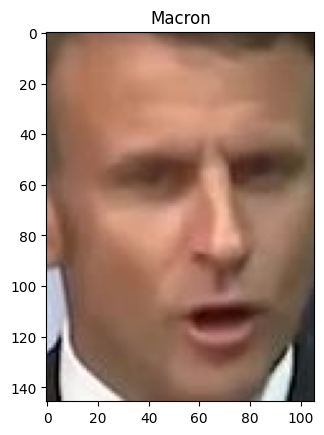

In [ ]:
# compute distances of query image and images in database
dists1 = [(e - query_embeddings[0]).norm().item() for e in embeddings]
# find the closest one
name = names[np.argmin(dists1)]

plt.imshow(query1); plt.title(name)


In [ ]:
# Step 2: Speeach Recognition

In [ ]:
# convert the vedio(.mp4) to audio(.wav)
clip = VideoFileClip(input_file)
clip.audio.write_audiofile("input.wav")


MoviePy - Writing audio in input.wav


MoviePy - Done.


In [ ]:
# divide the speech into sentences
def split_on_silence_with_timestamps(audio_path, min_silence_len=500, silence_thresh=-40):
    audio = AudioSegment.from_file(audio_path)

    # find the complete sentences by recognizing silence/chunk
    chunks = silence.split_on_silence(
        audio,
        min_silence_len=min_silence_len,
        silence_thresh=silence_thresh,
    )

    # get the start time of each sentence
    timestamps = []
    current_time = 0
    for chunk in chunks:
        timestamps.append(current_time)
        current_time += len(chunk)
    return chunks, timestamps

def recognize_audio_chunks_with_timestamps(chunks, timestamps, language="fr-FR"):
    recognizer = sr.Recognizer()
    results = []

    for i, chunk in enumerate(chunks):
        # set a temporary file to save the audio
        chunk.export(f"chunk_{i}.wav", format="wav")

        # load audio
        with sr.AudioFile(f"chunk_{i}.wav") as source:
            audio_listened = recognizer.record(source)

            try:
                # recognize the text in the audio
                text = recognizer.recognize_google(audio_listened, language=language)
                start_time = str(timedelta(seconds=timestamps[i]//1000))
                results.append(f"[{start_time}] Macron : {text}")
            except sr.UnknownValueError: # ignore the undentifiable content
                pass
            except sr.RequestError as e:
                pass

        # cancel the temporary file after recognization
        os.remove(f"chunk_{i}.wav")

    return results


audio_path = "input.wav"


# record the time stamp and content, then print the result (in original language)
audio_chunks, timestamps = split_on_silence_with_timestamps(audio_path)

transcript = recognize_audio_chunks_with_timestamps(audio_chunks, timestamps)

for result in transcript:
    print(result)


[0:00:00] Macron : nous devons bâtir ensemble un nouveau concept de sécurité commune et sur cette base et sur cette base seulement
[0:00:08] Macron : définir les capacités dont nous avons besoin les projets communs à construire
[0:00:14] Macron : les projets industriels technologiques et d'innovation à construire ensemble en européen


In [ ]:
# Step 3: Language Translation

In [ ]:
# use hugging face model to setup the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
tokenizer = AutoTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

# creating a Text2TextGenerationPipeline
# translate French into English
source_language = 'fra_Latn'
target_language = 'eng_Latn'
translator_fr_en = pipeline(task='translation', model=model, tokenizer=tokenizer, src_lang=source_language, tgt_lang=target_language)

def translate_text(text):
    translation = translator_fr_en(text)
    return translation[0]['translation_text']


# parsing timestamps and text content
def parse_transcript(transcript):
    pattern = r'\[(.*?)\] Macron : (.*)'
    entries = re.findall(pattern, transcript)
    return entries

# translate timestams and text content
def translate_transcript(entries):
    translated_entries = []
    for time, text in entries:
        translated_text = translate_text(text)
        translated_entries.append(f"[{time}] Macron : {translated_text}")
    return translated_entries


# because in the last part I got timestamp, punctuation and text,
# so change all of them to string to ensure successful transcription
if isinstance(transcript, list):
    transcript = "\n".join(transcript)
else:
    transcript = transcript.strip()


# translate the saved text and print the final result
entries = parse_transcript(transcript)

translated_entries = translate_transcript(entries)

for sentence in translated_entries:
    print(sentence)


[0:00:00] Macron : We must build together a new concept of common security and on this basis and only on this basis
[0:00:08] Macron : define the capacities we need for joint projects to build
[0:00:14] Macron : the technological and innovation industrial projects to be built together in Europe
